## Exploratory Data Analysis

### Finding data distribution and outliers

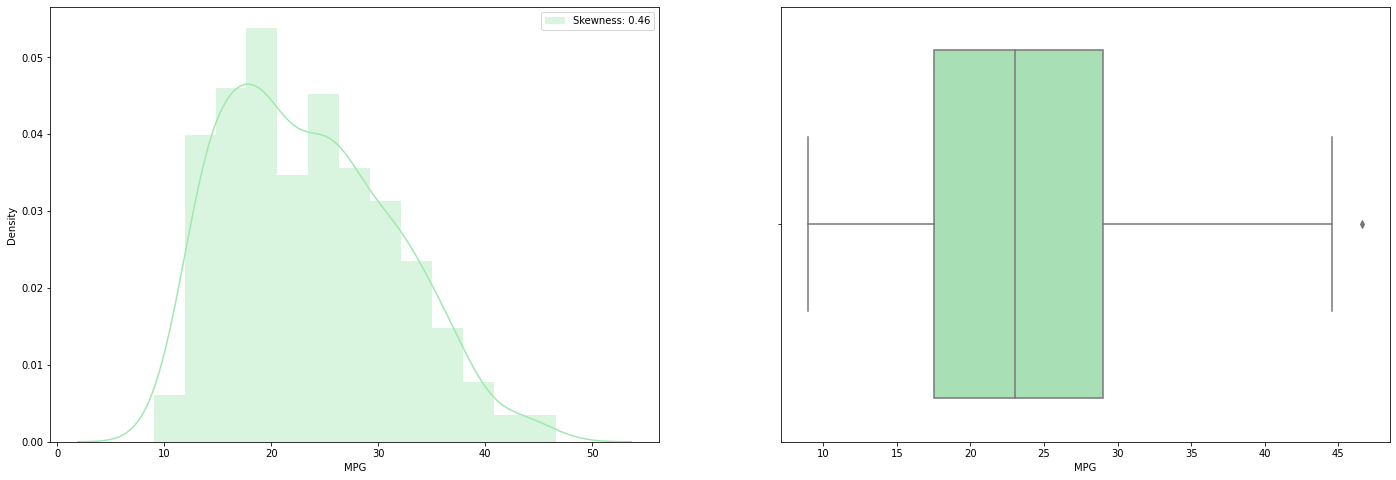

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

dataset_path = keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
t=sns.distplot(dataset['MPG'],label='Skewness: %.2f'%(dataset['MPG'].skew()) )
t.legend()
plt.subplot(1,2,2)
sns.set_palette(sns.color_palette(["#A0E8AF"]))
sns.boxplot(x=dataset['MPG'])
plt.show()

### Look at the feature correlations

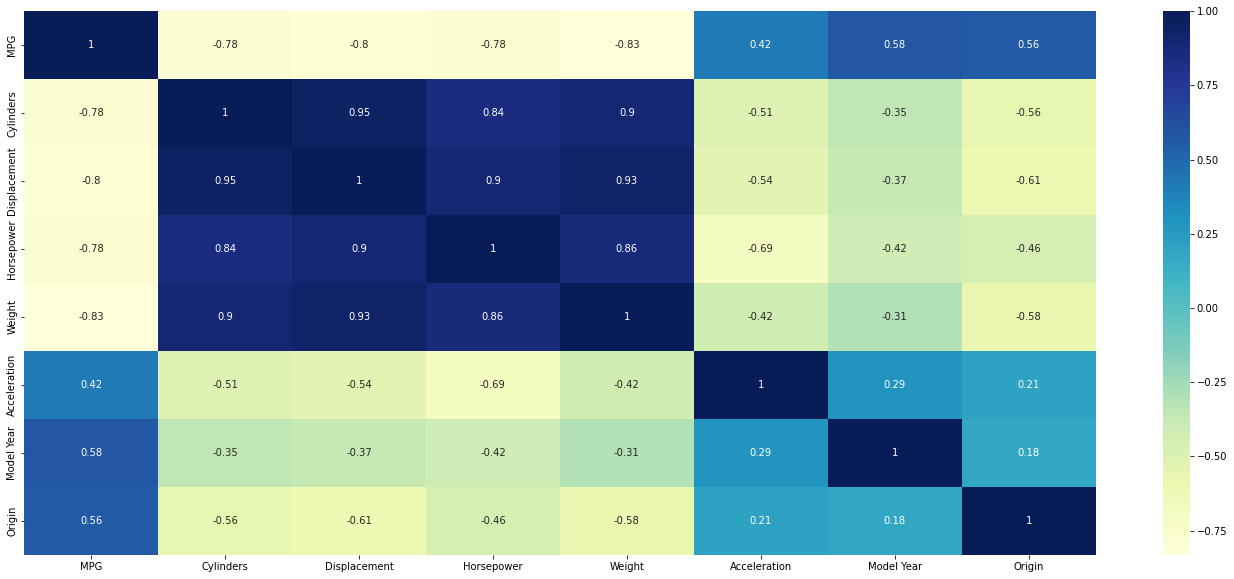

In [7]:
plt.figure(figsize  = (24,10))
sns.heatmap(dataset.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [8]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


## Set Variables

In [1]:
PROJECT_ID='jchavezar-demo' # Change it
REGION='us-central1'
TRAIN_IMAGE_URI=f'gcr.io/{PROJECT_ID}/custom_train:v1'
PREDICT_IMAGE_URI=f'gcr.io/{PROJECT_ID}/custom_predict:v1'
PIPELINE_ROOT_PATH='gs://vtx-root-path' # Change it
AIP_STORAGE_URI='gs://vtx-artifacts'

## Create Folder Structure

In [129]:
!rm -fr custom_train_job
!mkdir custom_train_job
!mkdir custom_train_job/train
!mkdir custom_train_job/prediction
!touch custom_train_job/train/__init__.py
!touch custom_train_job/prediction/__init__.py

## Build Training Model code

### Preprocessing for Training and Serving

In [6]:
%%writefile custom_train_job/train/preprocess.py

import os
import sys
import pandas as pd


data_uri = os.environ['AIP_STORAGE_URI']

## Data Cleaning and Normalizating, exporting statistics.

def train_pre_process(dataset):

    # Cleaning data and doing transformations

    dataset = dataset.dropna()
    dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
    
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    
    train_stats = train_dataset.describe()
    train_stats.pop('MPG')
    train_stats = train_stats.transpose()

    # Storing stats for transformations in Google Cloud Storage

    train_stats.to_csv(f'{data_uri}/mpg/stats.csv')
    train_labels = train_dataset.pop('MPG')
    test_labels = test_dataset.pop('MPG')
    
    # Standarization (Z-Score Normalization)

    def norm(x):
        return (x - train_stats['mean'])/train_stats['std']
    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)

    return normed_train_data, train_labels, normed_test_data, test_labels

## Using training statistics to equals standarization.

def pred_data_process(data: list):
    column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
    region_list = ['USA', 'Europe', 'Japan']
    
    dataset = pd.DataFrame([data], columns=column_names)
    dataset = dataset.dropna()

    for data in region_list:
        if dataset['Origin'][0] == data:
            dataset[data] = 1
        else: dataset[data] = 0
    
    dataset = dataset.drop(columns=['Origin'])

    ## Train stats
    train_stats = pd.read_csv(f'{data_uri}/mpg/stats.csv', index_col=[0])
    
    def norm(x):
        return (x - train_stats['mean'])/train_stats['std']
    
    return norm(dataset)

Overwriting custom_train_job/train/preprocess.py


In [7]:
!cp custom_train_job/train/preprocess.py custom_train_job/prediction/preprocess.py

### Training Code

In [8]:
%%writefile custom_train_job/train/train.py

import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_uri = os.environ['AIP_STORAGE_URI']

def build_model(train_data):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse'])
    
    return model

def train_model(train_data, train_labels, epochs: int = 1000):
    
    print('[INFO] ------ Building Model Layers', file=sys.stderr)
    model = build_model(train_data)
    epochs = epochs
    
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    print('[INFO] ------ Iterations / Training', file=sys.stderr)
    early_history = model.fit(train_data, train_labels, 
        epochs=epochs, validation_split = 0.2, 
        callbacks=[early_stop])
    
    print('[INFO] ------ Saving Model', file=sys.stderr)
    model.save(f'{model_uri}/mpg/model')

    return model

Overwriting custom_train_job/train/train.py


In [9]:
%%writefile custom_train_job/train/main.py

import sys
import preprocess
import train
import pandas as pd
from tensorflow import keras

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

## Clean, Normalize and Split Data

print('[INFO] ------ Preparing Data', file=sys.stderr)
train_data, train_labels, test_data, test_labels = preprocess.train_pre_process(dataset)

## Train model and save it in Google Cloud Storage

print('[INFO] ------ Training Model', file=sys.stderr)
train.train_model(train_data, train_labels)

Overwriting custom_train_job/train/main.py


### Container Image

In [10]:
%%writefile custom_train_job/train/Dockerfile

FROM python:latest

RUN python -m pip install --upgrade pip
RUN pip install pandas gcsfs tensorflow
COPY / /trainer

CMD ["python", "trainer/main.py"]

Overwriting custom_train_job/train/Dockerfile


In [ ]:
!gcloud builds submit -t $TRAIN_IMAGE_URI custom_train_job/train/.

## Create Serving with Transformation

In [12]:
%%writefile custom_train_job/prediction/main.py

from fastapi import Request, FastAPI
import tensorflow as tf
import json
import os
import preprocess
import sys

app = FastAPI()

model_uri=os.environ['AIP_STORAGE_URI']
print(f'[INFO] ------ {model_uri}', file=sys.stderr)
model = tf.keras.models.load_model(f'{model_uri}/mpg/model')

@app.get('/')
def get_root():
    return {'message': 'Welcome mpg API: miles per gallon prediction'}

@app.get('/health_check')
def health():
    return 200

if os.environ.get('AIP_PREDICT_ROUTE') is not None:
    method = os.environ['AIP_PREDICT_ROUTE']
else:
    method = '/predict'

@app.post(method)
async def predict(request: Request):
    print("----------------- PREDICTING -----------------")
    body = await request.json()
    instances = body["instances"]
    norm_data = preprocess.pred_data_process(instances)
    outputs = model.predict(norm_data)
    response = outputs.tolist()
    print("----------------- OUTPUTS -----------------")
    return {"predictions": response}

Writing custom_train_job/prediction/main.py


## Container Image for Serving/Prediction

In [13]:
%%writefile custom_train_job/prediction/Dockerfile

FROM tiangolo/uvicorn-gunicorn-fastapi:python3.7

COPY / /app
WORKDIR /app
RUN python -m pip install --upgrade pip
RUN pip install pandas gcsfs tensorflow
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8080"]

EXPOSE 8080

Writing custom_train_job/prediction/Dockerfile


In [ ]:
!gcloud builds submit -t $PREDICT_IMAGE_URI custom_train_job/prediction/.

## Create Pipeline

In [19]:
## Training Worker Specs

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4"
        },
        "replica_count": "1",
        "container_spec": {
            "image_uri": TRAIN_IMAGE_URI,
            "env": [
                {
                    "name": "AIP_STORAGE_URI",
                    "value": AIP_STORAGE_URI
                },
            ]
        }
    }
]

In [20]:
from kfp.v2.dsl import pipeline
from kfp.v2.components import importer_node
from google_cloud_pipeline_components import aiplatform as gcc
from google_cloud_pipeline_components.types import artifact_types
from google_cloud_pipeline_components.v1.custom_job import CustomTrainingJobOp

@pipeline(name='custom-train')
def pipeline(
    project_id: str
):
    train_job = CustomTrainingJobOp(
        project=project_id,
        display_name='custom_train',
        worker_pool_specs=worker_pool_specs
    )
    import_unmanaged_model_op = importer_node.importer(
            artifact_uri=AIP_STORAGE_URI,
            artifact_class=artifact_types.UnmanagedContainerModel,
            metadata={
                "containerSpec": {
                    "imageUri": PREDICT_IMAGE_URI,
                    "env": [
                        {
                            "name": "PROJECT_ID",
                            "value": PROJECT_ID},
                    ],
                    "predictRoute": "/predict",
                    "healthRoute": "/health_check",
                    "ports": [
                        {
                            "containerPort": 8080
                        }
                    ]
                },
            },
    ).after(train_job)
    custom_model_upload_job = gcc.ModelUploadOp(
        project=PROJECT_ID,
        display_name="customjob-model",
        unmanaged_container_model=import_unmanaged_model_op.outputs["artifact"],
        ).after(import_unmanaged_model_op)
    endpoint_create_job = gcc.EndpointCreateOp(
        project=PROJECT_ID,
        display_name="cutomjob-endpoint",
    )
            
    custom_model_deploy_job = (gcc.ModelDeployOp(
        model=custom_model_upload_job.outputs["model"],
        endpoint=endpoint_create_job.outputs["endpoint"],
        deployed_model_display_name="cutomjob-deploy",
        traffic_split={"0":"100"},
        dedicated_resources_machine_type="n1-standard-2",
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=1
        )).set_caching_options(False)

In [21]:
from kfp.v2 import compiler
import warnings
warnings.filterwarnings('ignore')

compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='custom_train.json')

In [22]:
import google.cloud.aiplatform as aip

job = aip.PipelineJob(
    display_name="custom_train",
    template_path="custom_train.json",
    pipeline_root=PIPELINE_ROOT_PATH,
    parameter_values={
        "project_id": PROJECT_ID
    },
)

job.submit()

Creating PipelineJob
PipelineJob created. Resource name: projects/569083142710/locations/us-central1/pipelineJobs/custom-train-20220919181712
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/569083142710/locations/us-central1/pipelineJobs/custom-train-20220919181712')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/custom-train-20220919181712?project=569083142710


![](images/vertex-pipe-customtrainjobop-fastapi.png)